# Opis zmiennych

In [8]:
# This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
# X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
# X2: Gender (1 = male; 2 = female).
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
# X4: Marital status (1 = married; 2 = single; 3 = others).
# X5: Age (year).
# X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
# X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
# X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [9]:
# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import time
from math import sqrt
from tqdm import tqdm_notebook as tqdm  # zamiast 'from tqdm import tqdm'
import holidays

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection
from sklearn.feature_selection import RFECV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# interpretowalność modelu
import shap
shap.initjs()

# zapisanie modelu
import joblib

# settings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

In [10]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


# Zrozumienie danych

In [11]:
dataframe = pd.read_excel('Files/default_of_credit_card_clients.xls')
dataframe.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


##### Usuwam nagłówki główne, które niewiele mówią i pozostawiam tylko te, które opisują daną kolumnę

In [12]:
dataframe = pd.read_excel('Files/default_of_credit_card_clients.xls', header=1)

In [13]:
dataframe = dataframe.rename(columns={'default payment next month': 'y'})
dataframe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


##### Sprawdzam brakujące dane

In [14]:
dataframe.isnull().mean()*100

ID           0.0
LIMIT_BAL    0.0
SEX          0.0
EDUCATION    0.0
MARRIAGE     0.0
AGE          0.0
PAY_0        0.0
PAY_2        0.0
PAY_3        0.0
PAY_4        0.0
PAY_5        0.0
PAY_6        0.0
BILL_AMT1    0.0
BILL_AMT2    0.0
BILL_AMT3    0.0
BILL_AMT4    0.0
BILL_AMT5    0.0
BILL_AMT6    0.0
PAY_AMT1     0.0
PAY_AMT2     0.0
PAY_AMT3     0.0
PAY_AMT4     0.0
PAY_AMT5     0.0
PAY_AMT6     0.0
y            0.0
dtype: float64

##### Sprawdzamy czy są duplikaty dla kolumny 'ID'

In [15]:
dataframe.loc[dataframe.duplicated(subset='ID', keep=False), :]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,y


##### Sprawdzamy rozkład dla 'default payment next month'

In [16]:
value_counts = dataframe['y'].value_counts()
value_counts

y
0    23364
1     6636
Name: count, dtype: int64

##### Sprawdzamy dane w kolumnie 'Education'. Jeżeli będą jakieś błędne dane to je skorygujemy. Wprowadzimy odpowiednie nazwy ukończonych szkół

In [17]:
education_counts = dataframe['EDUCATION'].value_counts()
education_counts

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [18]:
# Nie mamy szkoły 0, 5 i 6. W takim razie będą one ustawione jako 4 (others)
dataframe['EDUCATION'].replace([0, 5, 6], 4, inplace=True)
education_counts = dataframe['EDUCATION'].value_counts()
education_counts

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

##### Sprawdzamy dane w kolumnie 'SEX'. Jeżeli będą jakieś błędne dane to je skorygujemy. Wprowadzimy odpowiednie nazwy płci

In [19]:
sex_counts = dataframe['SEX'].value_counts()
sex_counts

SEX
2    18112
1    11888
Name: count, dtype: int64

##### Sprawdzamy dane w kolumnie 'MARRIAGE'. Jeżeli będą jakieś błędne dane to je skorygujemy. Wprowadzimy odpowiednie nazwy statusów

In [20]:
marriage_counts = dataframe['MARRIAGE'].value_counts()
marriage_counts

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

In [21]:
# Nie mamy statusu '0', więc przypiszemy go do statusu nr '3 (others)'
dataframe['MARRIAGE'].replace([0], 3, inplace=True)
marriage_counts = dataframe['MARRIAGE'].value_counts()
marriage_counts

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

##### Sprawdzę jeszcze describe dla tabeli, żeby sprawdzić czy nie ma tam jakiś dziwnych sktajnych danych (min i max)

In [23]:
# pd.set_option('display.max_columns', None)
# dataframe.describe()
result = dataframe.agg(['min', 'max'])
print(result)

        ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
min      1      10000    1          1         1   21     -2     -2     -2   
max  30000    1000000    2          4         3   79      8      8      8   

     PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
min     -2  ...    -170000     -81334    -339603         0         0   
max      8  ...     891586     927171     961664    873552   1684259   

     PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  y  
min         0         0         0         0  0  
max    896040    621000    426529    528666  1  

[2 rows x 25 columns]


##### Korelacja

<Axes: >

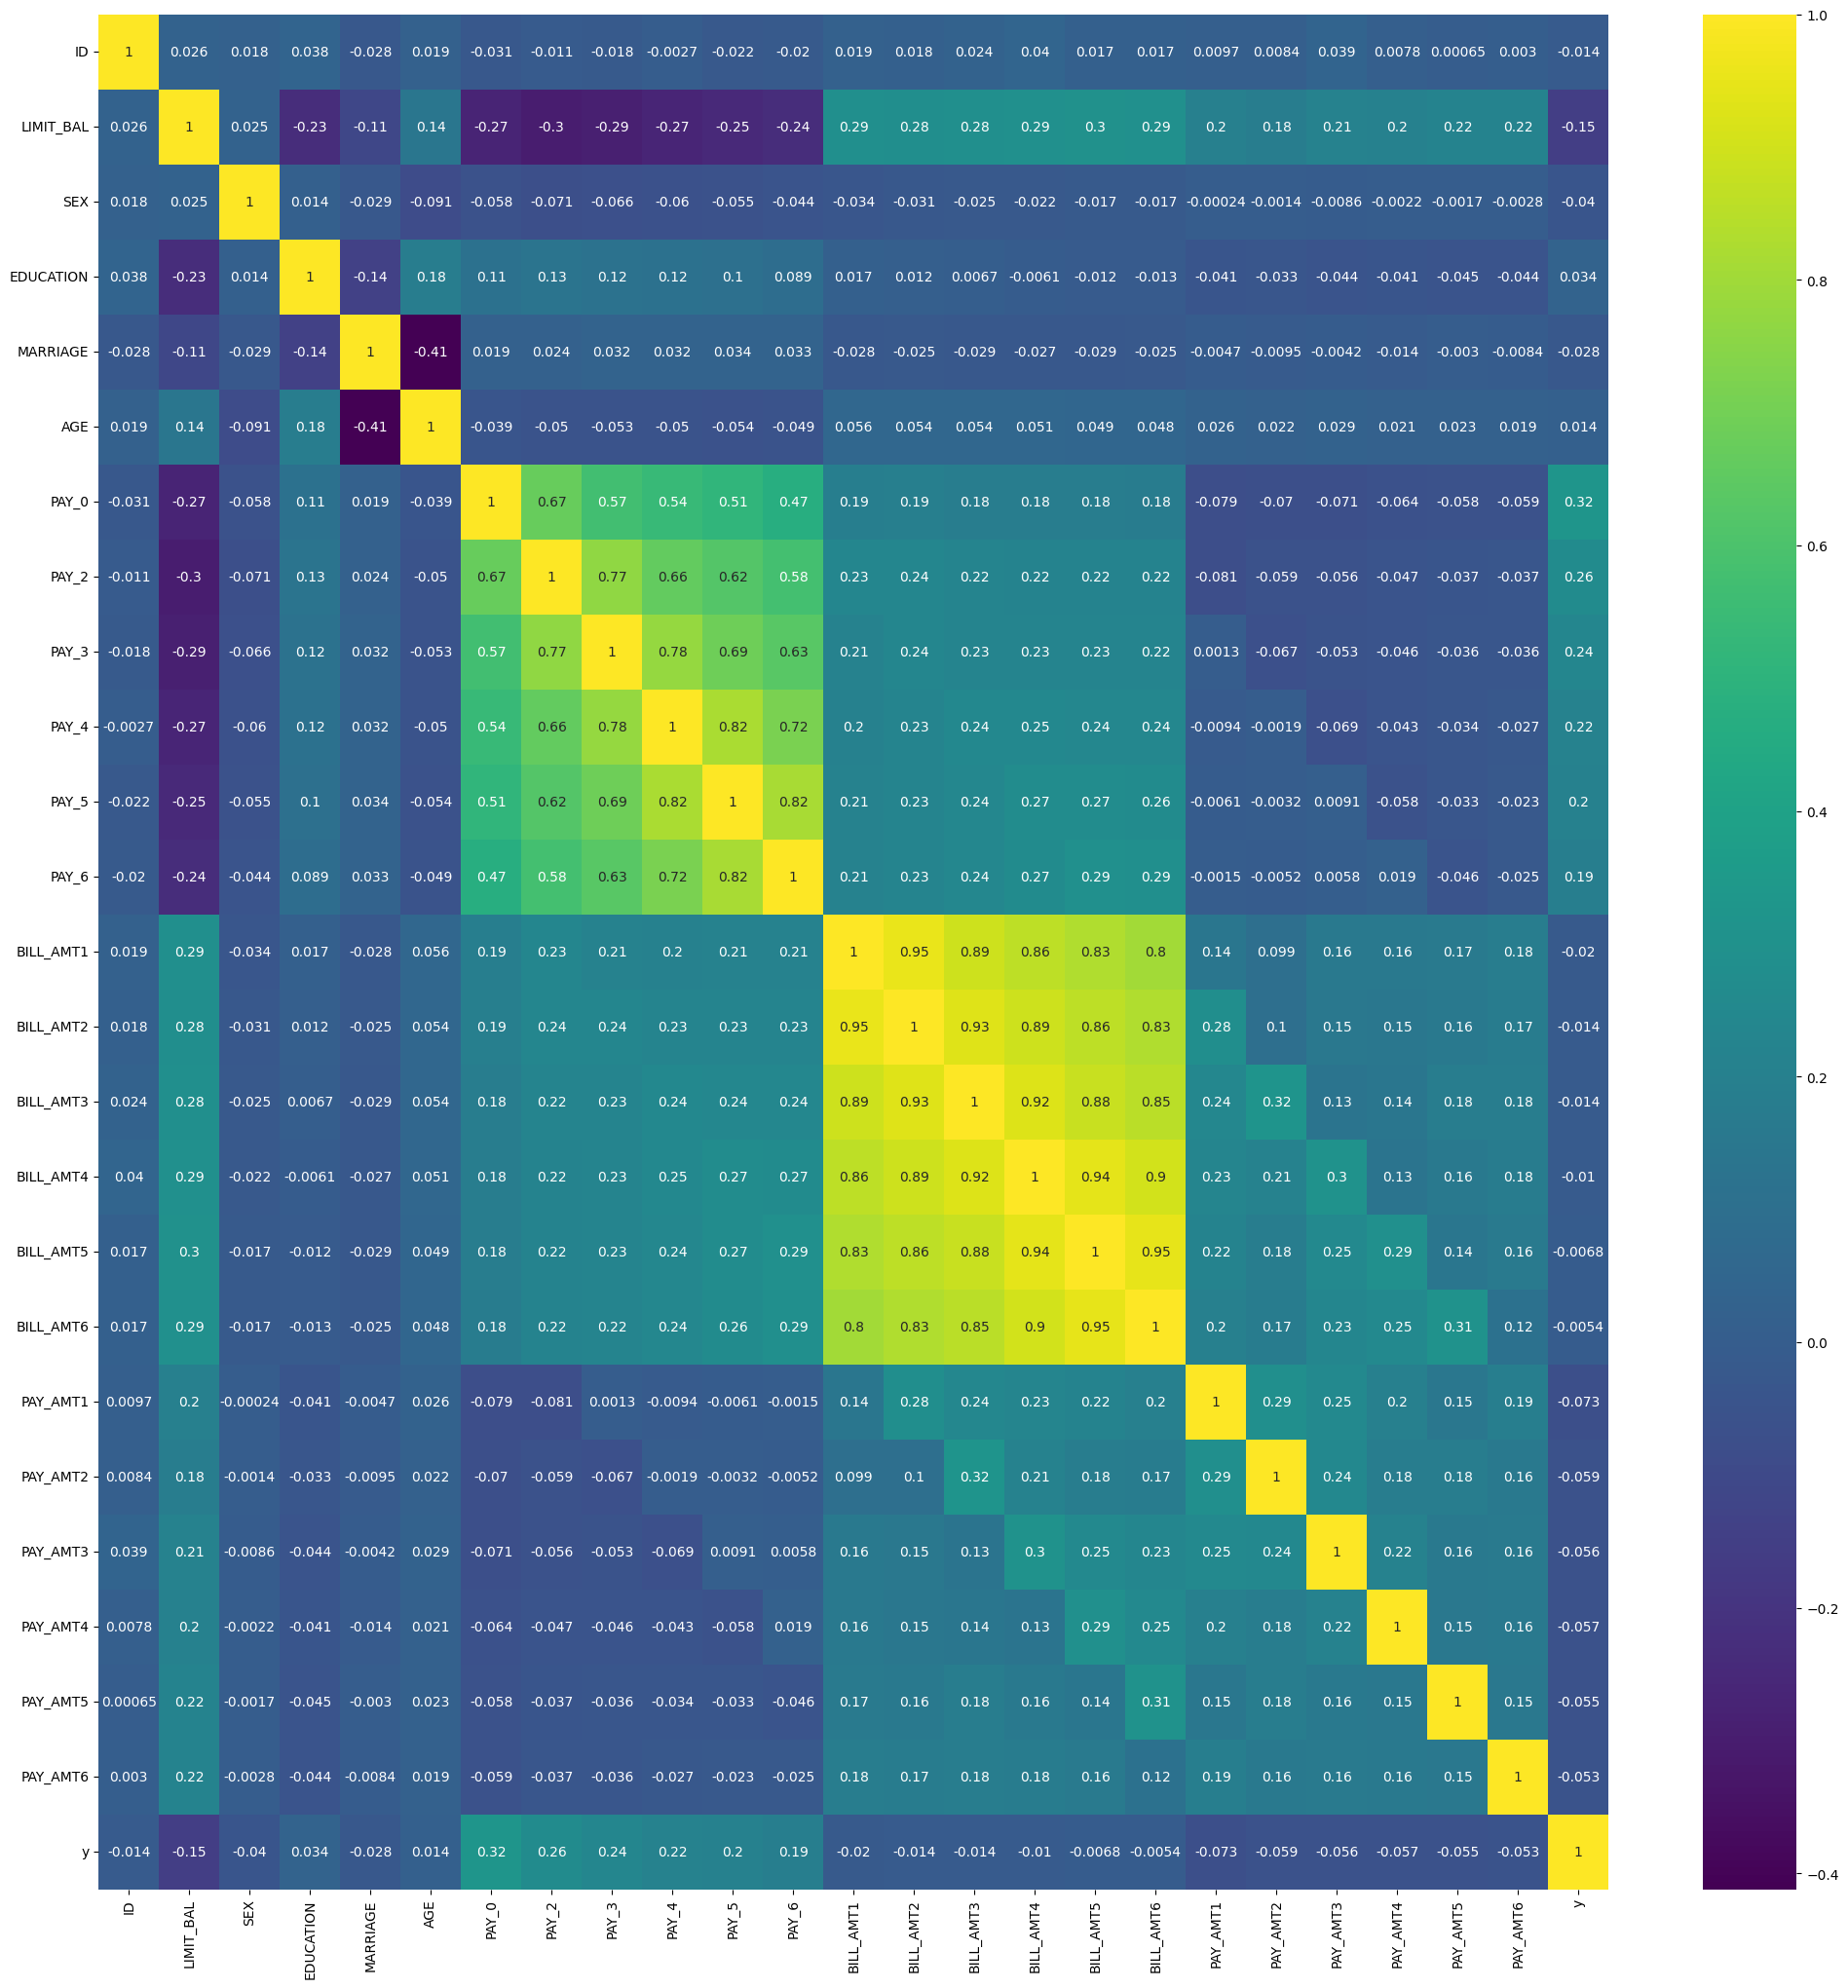

In [24]:
dataframe_numerical = dataframe.select_dtypes(include=['float64', 'int64'])
corr = dataframe_numerical.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr, annot=True, cmap='viridis')

In [25]:
# Pozytywne korelacje występują dla kolumn Bill_AMT oraz dla kolumn Pay_AMT. 
# Korelacje w tych obszarach rosną i maleją proporcjonalnie do badanych okresów do okresu
# Poza tym nic ciekawego

##### Usunięcie kolumny 'ID' i podział danych na X i y

In [26]:
def preprocessing_input(dataframe):
    dataframe = dataframe.copy()
    
    dataframe = dataframe.drop('ID', axis=1)
    
    X = dataframe.drop('y', axis=1).copy()
    y = dataframe['y'].copy()
    
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
    
    return X, y

In [27]:
X, y = preprocessing_input(dataframe)

In [28]:
X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.211870,-1.068797,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.211870,0.849131,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.211870,0.849131,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.211870,-1.068797,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.211870,-1.068797,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,-1.234323,1.555086,-1.068797,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,...,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130
29996,-0.134759,-1.234323,1.555086,0.849131,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,...,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382
29997,-1.059646,-1.234323,0.211870,0.849131,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,...,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001
29998,-0.674276,-1.234323,1.555086,-1.068797,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,...,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904


## Trenowanie

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=1234)

In [30]:
models = {
    LogisticRegression(): "Logistic Regression",
    SVC(): "SVC",
    MLPClassifier(): "MLPClassifier"
}

for model in models.keys():
    model.fit(X_train, y_train)

In [31]:
trained_models = {}

for model, name in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

for name, model in trained_models.items():
    score = model.score(X_test, y_test)
    print(f"{name} - Score: {score}")

Logistic Regression - Score: 0.8115555555555556
SVC - Score: 0.8208888888888889
MLPClassifier - Score: 0.8095555555555556


In [32]:
############################